**NOTEBOOK - PROJET ANNUEL**

# BLOC 1 : IMPORT #



In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.metrics import Precision, Recall
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
import matplotlib.pyplot as plt
import time

# BLOC 2 : CHARGEMENT ET TRAITEMENT DES DONNEES TEST #

* **CHARGEMENT DONNÉES**
* **DATAFRAME --> TABLEAU IMAGE 28x28 EN NIVEAUX DE GRIS** 
* **NORMALISATION DES VALEUERS DE PIXELS ENTRE 0 ET 1**

In [3]:
test_data_kaggle = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
test_data_normalized = test_data_kaggle.values.reshape(-1, 28, 28, 1) / 255.0  # normalisation

# BLOC 3 : CHARGEMENT ET TRAITEMENT DES DONNEES TEST #

* **CHARGEMENT ENSEMBLE DE DONNÉES MNIST DEPUIS UN FICHIER CSV**
* **EXTRACTION DES ÉTIQUETTES ET DES IMAGES**
* **SUPPRESSION COLONNE LABEL** : 

    La colonne 'label' contient les étiquettes de classification pour chaque image (le chiffre réel que l'image représente). Pour le traitement de données : 

    - Les images elles-mêmes sont nos caractéristiques, et sont stockées dans x_train et x_test.
    - Les étiquettes correspondent à nos cibles, et sont stockées dans y_train et y_test.
    - Pour éviter toute confusion et pour séparer clairement les caractéristiques des cibles, on       supprime alors la colonne 'label' du DataFrame des caractéristiques. Cela permet aussi de       s'assurer que les dimensions des données correspondent à ce que le modèle attend (une           image 28x28 et non une image 28x29 avec une colonne d'étiquettes).


* **NORMALISATION DES VALEURS DE PIXELS ENTRE 0 ET 1** :

    - Les algorithmes d'apprentissage profond, en particulier les réseaux de neurones,                 convergent plus rapidement si les caractéristiques ont des échelles similaires.
    - Cela empêche que des poids et des biais dans le réseau atteignent de très grandes ou très       petites valeurs, qui peuvent provoquer des problèmes numériques.
    - Certains fonctions d'activation, comme la sigmoid ou la tanh, sont saturées pour des             valeurs loin de 0, ce qui peut provoquer des problèmes d'apprentissage si les entrées ne         sont pas normalisées.

In [4]:
def load_mnist_data():
    train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
    y_train = train_data["label"].values
    x_train = train_data.drop(columns=["label"]).values.reshape(-1, 28, 28, 1) / 255.0
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = load_mnist_data()

# BLOC 4 : MODELE CNN (DEEPLEARNING) #

1. **Création du modèle CNN :**

    Le modèle est défini en utilisant l'API Sequential de Keras (tf). Cela crée un empilement de couches, dont chacune est définie par ses     propres paramètres (nombre de neurones, taille des filtres, fonction d'activation, etc.).

2. **Compilation du modèle :**

    On spécifie l'optimiseur ('adam'), la fonction de perte ('sparse_categorical_crossentropy'), et la métrique de confusion. Cette étape     prépare le modèle pour l'entraînement en définissant comment il doit apprendre à partir des données.

3. **Entraînement du modèle :**

    Avec model.fit(), le modèle est entraîné sur l'ensemble d'entraînement (x_train, y_train) pour un certain nombre d'epochs et une           taille de batch donnée. Les données de validation (x_test, y_test) sont également fournies pour évaluer les performances du modèle à       chaque epoch.

4. **Prédiction avec le modèle :**

    Une fois que le modèle est entraîné, on peut l'utiliser pour faire des prédictions. model.predict(x_test) renvoie les probabilités que     chaque image de l'ensemble de test appartienne à chacune des 10 classes.

5. **Traitement des prédictions :**

    Les prédictions sont traitées avec np.argmax(y_pred, axis=1) pour convertir les probabilités en prédictions de classe réelles.

6. **Évaluation des prédictions:**

    On calcule et affiche la matrice de confusion pour voir comment le modèle performe sur l'ensemble de test.

Epoch 1/5
525/525 [==============================] - 12s 22ms/step - loss: 0.2311 - accuracy: 0.9329 - val_loss: 0.1031 - val_accuracy: 0.9695
Epoch 2/5
525/525 [==============================] - 11s 21ms/step - loss: 0.0741 - accuracy: 0.9787 - val_loss: 0.0815 - val_accuracy: 0.9750
Epoch 3/5
525/525 [==============================] - 11s 21ms/step - loss: 0.0474 - accuracy: 0.9860 - val_loss: 0.0602 - val_accuracy: 0.9829
Epoch 4/5
525/525 [==============================] - 11s 22ms/step - loss: 0.0322 - accuracy: 0.9898 - val_loss: 0.0648 - val_accuracy: 0.9810
Epoch 5/5
263/263 [==============================] - 1s 5ms/step


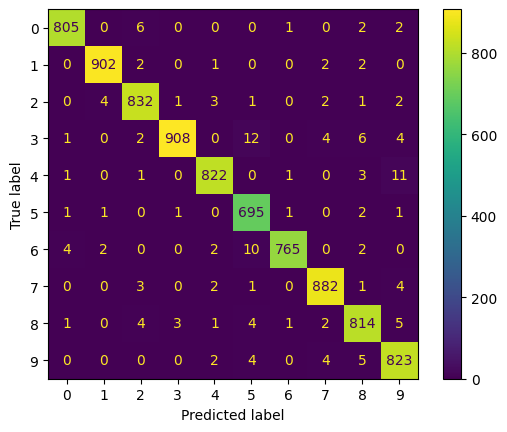

In [7]:
model = tf.keras.models.Sequential([
    
    # Couche d'entrée : spécifie la forme des images entrantes 
    # (28x28 pixels et 1 canal de couleur --> niveaux de gris).
    tf.keras.layers.Input(shape=(28, 28, 1)),
    
    # Couche de convolution : Passe un filtre de taille 3x3 sur l'image pour extraire des caractéristiques. 
    # Elle crée 32 cartes de caractéristiques.
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    
    # Couche de mise en commun (Pooling) : Réduit la taille des cartes de caractéristiques en prenant le maximum sur des blocs 2x2. 
    # Cela aide à réduire la dimensionnalité et à capturer les principales caractéristiques.
    tf.keras.layers.MaxPooling2D(2, 2),
    
    # Couche d'aplatissement (Flatten) : Transforme les cartes de caractéristiques 2D en un vecteur 1D 
    tf.keras.layers.Flatten(),
    
    # Couche entièrement connectée (Dense) : Connecte chaque neurone à chaque neurone de la couche précédente. 
    # Elle contient 128 neurones et utilise la fonction d'activation 'relu' => si un neuronne a une sortie négative alors 0.
    tf.keras.layers.Dense(128, activation='relu'),
    
    # Couche de sortie : Couche entièrement connectée avec 10 neurones (pour 10 classes de chiffres de 0 à 9). 
    # La fonction d'activation 'softmax' est utilisée pour transformer les scores en probabilités.
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_data=(x_test, y_test))

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_test, y_pred_classes)
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot(cmap='viridis')

plt.show()

# BLOC 5 : BLOC 4 + PLUSIEURS PARAMETRES #

Pareil quue le 'BLOC 4' mais ajout d'un dictionnaire qui stocke des paramètres différents pour (epochs et batch_size) afin d'obtenir plusieurs matrices de confusions et comparer les différents résultats. 

Epoch 1/12
525/525 [==============================] - 13s 23ms/step - loss: 0.2430 - accuracy: 0.9294 - val_loss: 0.1116 - val_accuracy: 0.9667
Epoch 2/12
525/525 [==============================] - 12s 23ms/step - loss: 0.0771 - accuracy: 0.9777 - val_loss: 0.0673 - val_accuracy: 0.9811
Epoch 3/12
525/525 [==============================] - 11s 22ms/step - loss: 0.0493 - accuracy: 0.9848 - val_loss: 0.0629 - val_accuracy: 0.9801
Epoch 4/12
525/525 [==============================] - 12s 22ms/step - loss: 0.0343 - accuracy: 0.9900 - val_loss: 0.0579 - val_accuracy: 0.9819
Epoch 5/12
525/525 [==============================] - 12s 23ms/step - loss: 0.0241 - accuracy: 0.9927 - val_loss: 0.0589 - val_accuracy: 0.9818
Epoch 6/12
525/525 [==============================] - 12s 22ms/step - loss: 0.0183 - accuracy: 0.9943 - val_loss: 0.0522 - val_accuracy: 0.9830
Epoch 7/12
525/525 [==============================] - 12s 23ms/step - loss: 0.0121 - accuracy: 0.9968 - val_loss: 0.0594 - val_accuracy:

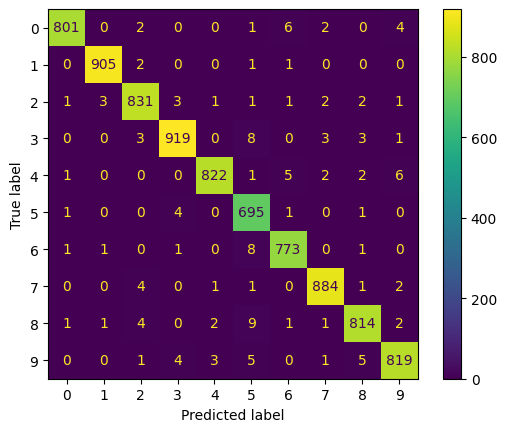

Epoch 1/12
33/33 [==============================] - 12s 338ms/step - loss: 0.7951 - accuracy: 0.8091 - val_loss: 0.3077 - val_accuracy: 0.9132
Epoch 2/12
33/33 [==============================] - 11s 320ms/step - loss: 0.2463 - accuracy: 0.9273 - val_loss: 0.2173 - val_accuracy: 0.9368
Epoch 3/12
33/33 [==============================] - 11s 323ms/step - loss: 0.1710 - accuracy: 0.9504 - val_loss: 0.1589 - val_accuracy: 0.9554
Epoch 4/12
33/33 [==============================] - 11s 334ms/step - loss: 0.1286 - accuracy: 0.9638 - val_loss: 0.1286 - val_accuracy: 0.9632
Epoch 5/12
33/33 [==============================] - 11s 323ms/step - loss: 0.1017 - accuracy: 0.9712 - val_loss: 0.1071 - val_accuracy: 0.9688
Epoch 6/12
33/33 [==============================] - 11s 320ms/step - loss: 0.0838 - accuracy: 0.9772 - val_loss: 0.0963 - val_accuracy: 0.9717
Epoch 7/12
33/33 [==============================] - 11s 337ms/step - loss: 0.0713 - accuracy: 0.9804 - val_loss: 0.0870 - val_accuracy: 0.9745

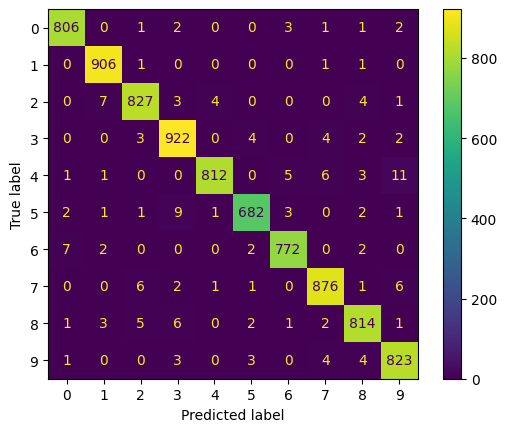

Epoch 1/20
33/33 [==============================] - 12s 330ms/step - loss: 0.7711 - accuracy: 0.7983 - val_loss: 0.3271 - val_accuracy: 0.9048
Epoch 2/20
33/33 [==============================] - 11s 324ms/step - loss: 0.2638 - accuracy: 0.9233 - val_loss: 0.2432 - val_accuracy: 0.9293
Epoch 3/20
33/33 [==============================] - 11s 325ms/step - loss: 0.1939 - accuracy: 0.9440 - val_loss: 0.1775 - val_accuracy: 0.9517
Epoch 4/20
33/33 [==============================] - 11s 327ms/step - loss: 0.1453 - accuracy: 0.9588 - val_loss: 0.1437 - val_accuracy: 0.9600
Epoch 5/20
33/33 [==============================] - 10s 319ms/step - loss: 0.1142 - accuracy: 0.9681 - val_loss: 0.1199 - val_accuracy: 0.9667
Epoch 6/20
33/33 [==============================] - 11s 322ms/step - loss: 0.0929 - accuracy: 0.9743 - val_loss: 0.1010 - val_accuracy: 0.9714
Epoch 7/20
33/33 [==============================] - 11s 328ms/step - loss: 0.0795 - accuracy: 0.9772 - val_loss: 0.0953 - val_accuracy: 0.9726

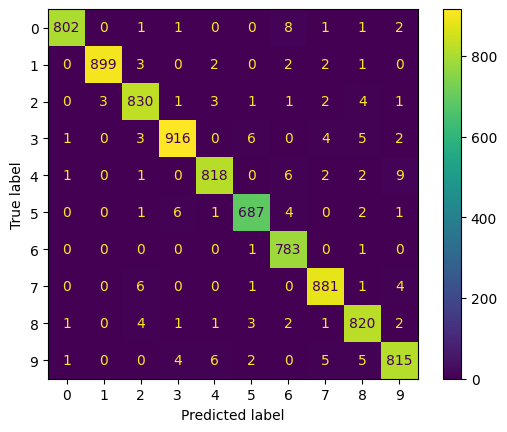

Epoch 1/12
17/17 [==============================] - 12s 660ms/step - loss: 1.2223 - accuracy: 0.7382 - val_loss: 0.4733 - val_accuracy: 0.8689
Epoch 2/12
17/17 [==============================] - 11s 628ms/step - loss: 0.3650 - accuracy: 0.8956 - val_loss: 0.2998 - val_accuracy: 0.9123
Epoch 3/12
17/17 [==============================] - 11s 628ms/step - loss: 0.2597 - accuracy: 0.9249 - val_loss: 0.2482 - val_accuracy: 0.9277
Epoch 4/12
17/17 [==============================] - 11s 666ms/step - loss: 0.2078 - accuracy: 0.9391 - val_loss: 0.2002 - val_accuracy: 0.9425
Epoch 5/12
17/17 [==============================] - 11s 632ms/step - loss: 0.1689 - accuracy: 0.9526 - val_loss: 0.1686 - val_accuracy: 0.9526
Epoch 6/12
17/17 [==============================] - 11s 659ms/step - loss: 0.1409 - accuracy: 0.9607 - val_loss: 0.1448 - val_accuracy: 0.9581
Epoch 7/12
17/17 [==============================] - 11s 652ms/step - loss: 0.1203 - accuracy: 0.9657 - val_loss: 0.1260 - val_accuracy: 0.9651

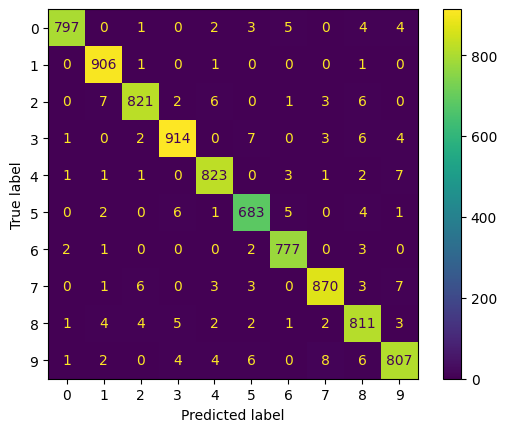

In [5]:
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Liste des paramètres epochs et batch_size pour matrices de confusion différentes
params = [(12, 64), (12, 1024), (20, 1024), (12, 2048)]

for epochs, batch_size in params:
    model = create_model()
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))
    
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
     cm = confusion_matrix(y_test, y_pred_classes)
    
    print(f"Epochs = {epochs} et batch_size = {batch_size} :")
    cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot(cmap='viridis')
    plt.show()


# BLOC 6 : BLOC 5 + ANALYSE PERFORMANCE #

Optimisation de l'affichage pour comparer plus facilement les résultats en calculant notament la somme des erreurs (valeur hors diagonale) et en les associant au valeur de batchs_size et epochs correspondants.

Epoch 1/12
525/525 [==============================] - 12s 22ms/step - loss: 0.2491 - accuracy: 0.9289 - val_loss: 0.0971 - val_accuracy: 0.9732
Epoch 2/12
525/525 [==============================] - 11s 22ms/step - loss: 0.0744 - accuracy: 0.9774 - val_loss: 0.0666 - val_accuracy: 0.9804
Epoch 3/12
525/525 [==============================] - 11s 22ms/step - loss: 0.0463 - accuracy: 0.9856 - val_loss: 0.0652 - val_accuracy: 0.9788
Epoch 4/12
525/525 [==============================] - 11s 21ms/step - loss: 0.0317 - accuracy: 0.9901 - val_loss: 0.0609 - val_accuracy: 0.9807
Epoch 5/12
525/525 [==============================] - 12s 22ms/step - loss: 0.0221 - accuracy: 0.9932 - val_loss: 0.0643 - val_accuracy: 0.9819
Epoch 6/12
525/525 [==============================] - 11s 22ms/step - loss: 0.0167 - accuracy: 0.9949 - val_loss: 0.0655 - val_accuracy: 0.9815
Epoch 7/12
525/525 [==============================] - 11s 21ms/step - loss: 0.0116 - accuracy: 0.9967 - val_loss: 0.0555 - val_accuracy:

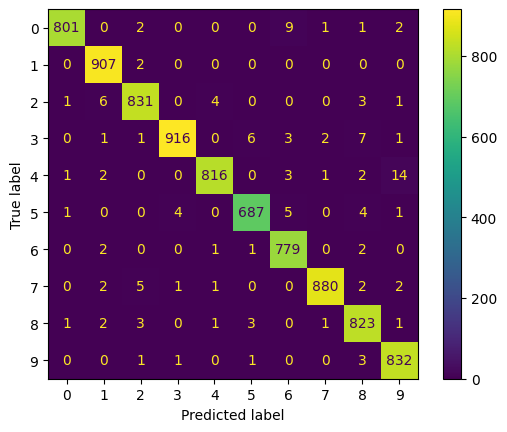

Epoch 1/12
33/33 [==============================] - 12s 336ms/step - loss: 0.8221 - accuracy: 0.7995 - val_loss: 0.3267 - val_accuracy: 0.9037
Epoch 2/12
33/33 [==============================] - 11s 321ms/step - loss: 0.2612 - accuracy: 0.9235 - val_loss: 0.2270 - val_accuracy: 0.9342
Epoch 3/12
33/33 [==============================] - 11s 322ms/step - loss: 0.1832 - accuracy: 0.9480 - val_loss: 0.1731 - val_accuracy: 0.9524
Epoch 4/12
33/33 [==============================] - 11s 333ms/step - loss: 0.1339 - accuracy: 0.9635 - val_loss: 0.1350 - val_accuracy: 0.9629
Epoch 5/12
33/33 [==============================] - 11s 321ms/step - loss: 0.1049 - accuracy: 0.9712 - val_loss: 0.1056 - val_accuracy: 0.9701
Epoch 6/12
33/33 [==============================] - 11s 320ms/step - loss: 0.0846 - accuracy: 0.9763 - val_loss: 0.0943 - val_accuracy: 0.9743
Epoch 7/12
33/33 [==============================] - 11s 334ms/step - loss: 0.0716 - accuracy: 0.9803 - val_loss: 0.0854 - val_accuracy: 0.9739

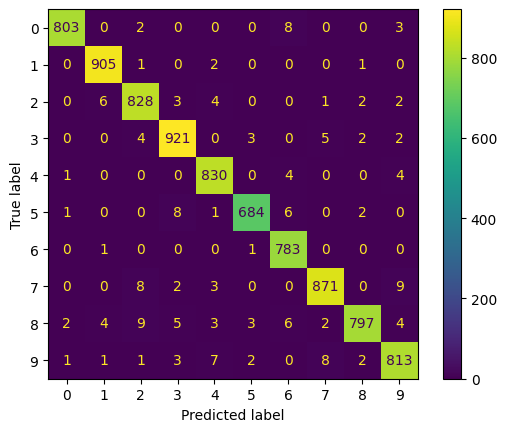

Epoch 1/20
33/33 [==============================] - 12s 334ms/step - loss: 0.7346 - accuracy: 0.8191 - val_loss: 0.3168 - val_accuracy: 0.9060
Epoch 2/20
33/33 [==============================] - 10s 319ms/step - loss: 0.2575 - accuracy: 0.9249 - val_loss: 0.2301 - val_accuracy: 0.9344
Epoch 3/20
33/33 [==============================] - 10s 319ms/step - loss: 0.1906 - accuracy: 0.9446 - val_loss: 0.1846 - val_accuracy: 0.9450
Epoch 4/20
33/33 [==============================] - 11s 332ms/step - loss: 0.1451 - accuracy: 0.9587 - val_loss: 0.1457 - val_accuracy: 0.9592
Epoch 5/20
33/33 [==============================] - 11s 320ms/step - loss: 0.1134 - accuracy: 0.9683 - val_loss: 0.1247 - val_accuracy: 0.9638
Epoch 6/20
33/33 [==============================] - 11s 321ms/step - loss: 0.0942 - accuracy: 0.9728 - val_loss: 0.0996 - val_accuracy: 0.9717
Epoch 7/20
33/33 [==============================] - 11s 334ms/step - loss: 0.0786 - accuracy: 0.9779 - val_loss: 0.0899 - val_accuracy: 0.9731

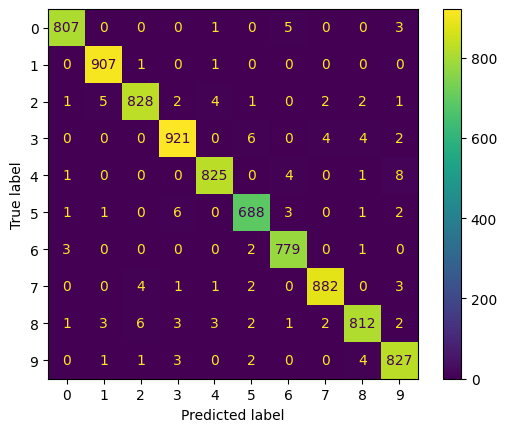

Epoch 1/12
17/17 [==============================] - 12s 644ms/step - loss: 1.1308 - accuracy: 0.7259 - val_loss: 0.4343 - val_accuracy: 0.8740
Epoch 2/12
17/17 [==============================] - 11s 646ms/step - loss: 0.3528 - accuracy: 0.8961 - val_loss: 0.3031 - val_accuracy: 0.9124
Epoch 3/12
17/17 [==============================] - 11s 664ms/step - loss: 0.2592 - accuracy: 0.9246 - val_loss: 0.2501 - val_accuracy: 0.9277
Epoch 4/12
17/17 [==============================] - 11s 637ms/step - loss: 0.2137 - accuracy: 0.9385 - val_loss: 0.2134 - val_accuracy: 0.9373
Epoch 5/12
17/17 [==============================] - 11s 637ms/step - loss: 0.1815 - accuracy: 0.9487 - val_loss: 0.1833 - val_accuracy: 0.9480
Epoch 6/12
17/17 [==============================] - 11s 662ms/step - loss: 0.1532 - accuracy: 0.9568 - val_loss: 0.1572 - val_accuracy: 0.9562
Epoch 7/12
17/17 [==============================] - 11s 636ms/step - loss: 0.1320 - accuracy: 0.9630 - val_loss: 0.1378 - val_accuracy: 0.9627

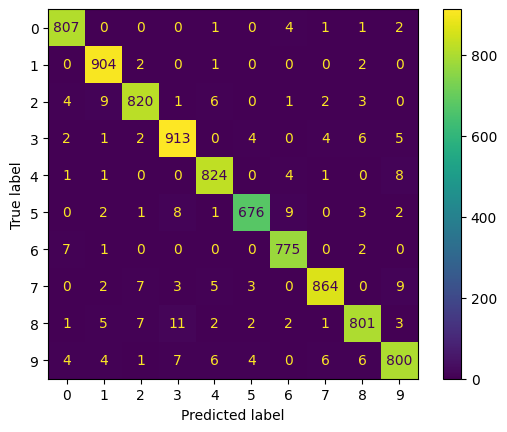

Epochs = 12, batch_size = 64: 128 erreurs
Epochs = 12, batch_size = 1024: 165 erreurs
Epochs = 20, batch_size = 1024: 124 erreurs
Epochs = 12, batch_size = 2048: 216 erreurs


In [6]:
# Modèle CNN (ajout layer)
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

params = [(12, 64), (12, 1024), (20, 1024), (12, 2048)]
errors = {}  # Dictionnaire pour stocker les erreurs pour chaque configuration

for epochs, batch_size in params:
    model = create_model()
    model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test))
    
    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    cm = confusion_matrix(y_test, y_pred_classes)
    
    total_errors = cm.sum() - np.diag(cm).sum()
    errors[(epochs, batch_size)] = total_errors
    
    print("\n")
    print(f"Epochs = {epochs} et batch_size = {batch_size} :")
    cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot(cmap='viridis')
    plt.show()

# Affichage des erreurs pour chaque configuration
for (epochs, batch_size), error in errors.items():
    print(f"Epochs = {epochs}, batch_size = {batch_size}: {error} erreurs")


# BLOC 7 : RANDOM FOREST #

1. **Initialisation du RandomForest**

2. **Traitement des données :**

    - Remodelage des images 2D de 28x28 pixels en vecteurs 1D de 784 éléments pour être compatibles avec le modèle de forêt aléatoire.
    
    
3. **Entraînement du modèle :**

    - Le modèle est entraîné en utilisant la méthode .fit(), qui prend les données d'entraînement remodelées et leurs étiquettes                 correspondantes.
    
    
4. **Prédiction avec le modèle entraîné :**

    - Après avoir été formé, le modèle est utilisé pour prédire les étiquettes des données de test.
    
    
5. **Affichage des résultats :**

    - Le rapport de classification est généré, donnant certains métriques comme la précision, le rappel et le score pour chaque classe.


6. **Création et affichage de la matrice de confusion**


RandomForest Results: 

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       816
           1       0.98      0.99      0.98       909
           2       0.97      0.96      0.96       846
           3       0.96      0.94      0.95       937
           4       0.96      0.97      0.96       839
           5       0.97      0.95      0.96       702
           6       0.97      0.98      0.97       785
           7       0.96      0.95      0.96       893
           8       0.95      0.95      0.95       835
           9       0.93      0.95      0.94       838

    accuracy                           0.96      8400
   macro avg       0.96      0.96      0.96      8400
weighted avg       0.96      0.96      0.96      8400



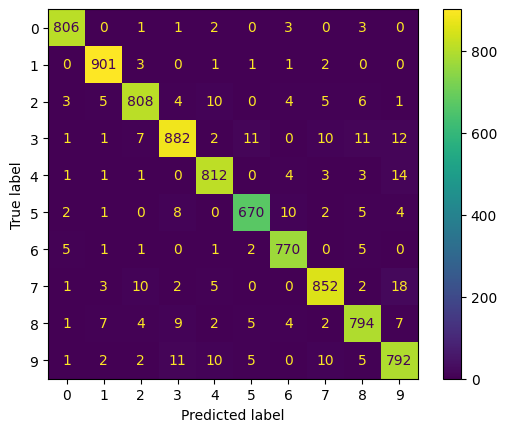

In [8]:
clf_rf = RandomForestClassifier()

clf_rf.fit(x_train.reshape(-1, 28*28), y_train)
y_pred_rf = clf_rf.predict(x_test.reshape(-1, 28*28))

print("RandomForest Results: \n")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_display_rf = ConfusionMatrixDisplay(cm_rf, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot(cmap='viridis')

plt.show()

# BLOC 8 : SVM #

1. **Initialisation du SVM**

2. **Traitement des données :**

    - Remodelage des images 2D de 28x28 pixels en vecteurs 1D de 784 éléments pour être compatibles avec le modèle de forêt aléatoire.
    
    
3. **Entraînement du modèle :**

    - Le modèle est entraîné en utilisant la méthode .fit(), qui prend les données d'entraînement remodelées et leurs étiquettes                 correspondantes.
    
    
4. **Prédiction avec le modèle entraîné :**

    - Après avoir été formé, le modèle est utilisé pour prédire les étiquettes des données de test.
    
    
5. **Affichage des résultats :**

    - Le rapport de classification est généré, donnant certains métriques comme la précision, le rappel et le score pour chaque classe.


6. **Création et affichage de la matrice de confusion**


SVM Results:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       816
           1       0.98      0.99      0.99       909
           2       0.98      0.97      0.97       846
           3       0.97      0.96      0.96       937
           4       0.96      0.97      0.97       839
           5       0.97      0.97      0.97       702
           6       0.98      0.99      0.98       785
           7       0.98      0.97      0.97       893
           8       0.97      0.97      0.97       835
           9       0.96      0.96      0.96       838

    accuracy                           0.97      8400
   macro avg       0.97      0.97      0.97      8400
weighted avg       0.97      0.97      0.97      8400



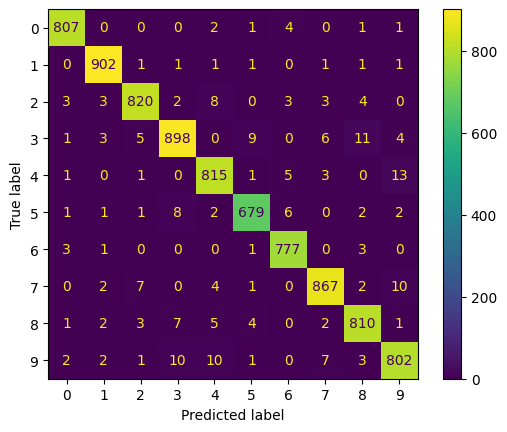

In [13]:
clf_svm = SVC()
clf_svm.fit(x_train.reshape(-1, 28*28), y_train)
y_pred_svm = clf_svm.predict(x_test.reshape(-1, 28*28))

print("SVM Results:/n")
print(classification_report(y_test, y_pred_svm))

cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_display_svm = ConfusionMatrixDisplay(cm_svm, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot(cmap='viridis')

plt.show()

# BLOC 9 : OPTIMISATION RANDOM FOREST (GRIDSEARCH vs RANDOMIZEDSEARCH) #

Lors de l'optimisation de notre modèle Random Forest, on a initialement envisagé d'utiliser GridSearchCV pour rechercher les meilleurs hyperparamètres. Cette méthode procède à une recherche exhaustive sur toutes les combinaisons possibles d'hyperparamètres spécifiés. Cependant, compte tenu de la vaste étendue des hyperparamètres à tester et du temps de calcul nécessaire pour chaque combinaison, cette approche est trop chronophage. Afin de trouver un compromis entre le temps de recherche et la qualité des hyperparamètres, nous avons opté pour RandomizedSearchCV. Cette méthode, plutôt que d'examiner toutes les combinaisons, effectue une recherche aléatoire sur un nombre fixe de combinaisons d'hyperparamètres, offrant ainsi un équilibre entre la performance et le temps de calcul. Dans notre cas, RandomizedSearchCV s'est avéré être un choix plus rapide et plus optimal pour l'ajustement des hyperparamètres du Random Forest.

In [16]:
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt', 'log2', 0.5, 0.7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid_rf, cv=3, verbose=2, n_jobs=-1)
grid_search_rf.fit(x_train.reshape(-1, 28*28), y_train)

y_pred_grid_rf = grid_search_rf.predict(x_test.reshape(-1, 28*28))

print("Optimized RandomForest with GridSearch Results:")
print(confusion_matrix(y_test, y_pred_grid_rf))
print(classification_report(y_test, y_pred_grid_rf))
print("Best parameters for RandomForest:", grid_search_rf.best_params_)

#Beaucoup trop long sur un jeu de donnée aussi gros

Fitting 3 folds for each of 1152 candidates, totalling 3456 fits


KeyboardInterrupt: 

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 1.5min
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 1.5min
[CV] END bootstrap=True, max_depth=30, max_features=0.5, min_samples_leaf=1, min_samples_split=10, n_estimators=50; total time= 1.5min
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   7.1s
[CV] END bootstrap=True, max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=50; total time=   7.0s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total ti

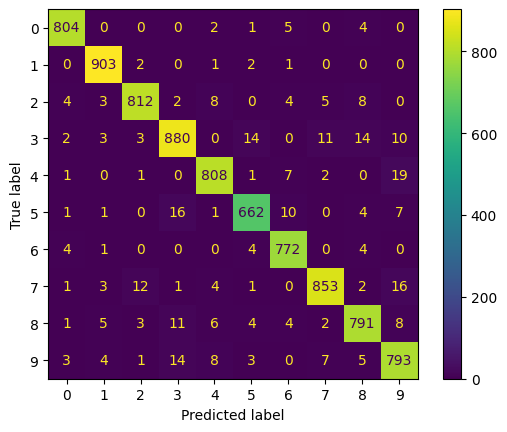

In [8]:
#RandomizedSearch pour RandomForest
param_distributions_rf = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [10, 20, 30, None],
    'max_features': ['sqrt', 'log2', 0.5, 0.7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

random_search_rf = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=param_distributions_rf, n_iter=3, cv=3, verbose=2)
random_search_rf.fit(x_train.reshape(-1, 28*28), y_train)

y_pred_random_rf = random_search_rf.predict(x_test.reshape(-1, 28*28))

print("\n \n")
print("Optimized RandomForest Results:")
print("Meilleurs paramètres pour RandomForest:\n", random_search_rf.best_params_)
print(classification_report(y_test, y_pred_random_rf))
print("\n \n")

cm_random_rf = confusion_matrix(y_test, y_pred_random_rf)
cm_display_random_rf = ConfusionMatrixDisplay(cm_random_rf, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]).plot(cmap='viridis')



# BLOC 10 : VITESSE DE PREDICTION #

Calcul du temps de prédiction pour chaque modèle puis affichage du top du plus rapide au moins rapide.

Résultat constaté : 

1- Optimized RandomForest - 1.04086 s

2- RandomForest - 1.19880 s

3- CNN - 4.15417 s

4- SVM - 198.76567 s

In [23]:
execution_times = []

# Pour le modèle CNN:
start_time = time.time()
predictions_dl = model.predict(test_data_normalized)
predictions_dl_classes = np.argmax(predictions_dl, axis=1)
end_time = time.time()
execution_times.append(("CNN", end_time-start_time))

# Pour le modèle RandomForest non optimisé:
start_time = time.time()
predictions_rf = clf_rf.predict(test_data_kaggle)
end_time = time.time()
execution_times.append(("RandomForest", end_time-start_time))

# Pour le modèle SVM:
start_time = time.time()
predictions_svm = clf_svm.predict(test_data_kaggle)
end_time = time.time()
execution_times.append(("SVM", end_time-start_time))

# Pour le modèle RandomForest optimisé:
start_time = time.time()
predictions_optimized_rf = random_search_rf.predict(test_data_kaggle)
end_time = time.time()
execution_times.append(("Optimized RandomForest", end_time-start_time))


execution_times_sorted = sorted(execution_times, key=lambda x: x[1])

print("\nTop Performance:")
for idx, (name, time_taken) in enumerate(execution_times_sorted, 1):
    print(f"{idx}- {name} - {time_taken:.5f} s")

875/875 [==============================] - 4s 4ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



Top Performance:
1- Optimized RandomForest - 1.04086 s
2- RandomForest - 1.19880 s
3- CNN - 4.15417 s
4- SVM - 198.76567 s
